<a href="https://colab.research.google.com/github/Vidit-D/PRODIGY_DS_04/blob/main/Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### twitter sentiment analysis#

In [ ]:
#SENTIMENT ANALYSIS INVOLVES EXAMINING TWEETS AND DETERMINING WHETHER THE TWEETS ARE POSITIVE,NEGATIVE,NEUTRAL OR IRRELEVANT
#IT INVOLVES UNDERSTANDING THE GENERAL MOOD OF THE PERSON ABOUT A SPECIFIC TOPIC

In [ ]:
#INSTALLING KAGGLE LIBRARY
! pip install kaggle


**UPLOAD KAGGLE.JSON FILE**

In [ ]:
#configure the path of Kaggle.json file
# Create the directory with lowercase 'k'
! mkdir -p ~/.kaggle

# Copy Kaggle.json to the correct directory
! cp kaggle.json ~/.kaggle/

# Set the correct permissions
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
#API TO FETCH THE DATASET FROM KAGGLE
!kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis


Dataset URL: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
License(s): CC0-1.0
  0% 0.00/1.99M [00:00<?, ?B/s]
100% 1.99M/1.99M [00:00<00:00, 172MB/s]


**IMPORTING TWITTER SENTIMENT DATASET**

In [ ]:
#extracting compressed dataset
from zipfile import ZipFile
dataset='/content/twitter-entity-sentiment-analysis.zip'
with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print("The dataset is extracted")


The dataset is extracted


**IMPORTING THE DEPENDENCIES**

In [ ]:
import numpy as np
import pandas as pd
import nltk
import re #REGULAR EXPRESSION
import seaborn as sns
from textblob import TextBlob
#import wordcloud from Wordcloud
import matplotlib.pyplot as plt
import cufflinks as cf

In [ ]:
#load the training dataset
traindf=pd.read_csv('twitter_training.csv',header=None,index_col=0)
# Load the validation (test) dataset
testdf = pd.read_csv('twitter_validation.csv',header=None,index_col=0)
#print(traindf.head())
#print(testdf.head())

In [ ]:
traindf=traindf[[2,3]].reset_index(drop=True)
testdf=testdf[[2,3]].reset_index(drop=True)

In [ ]:
traindf
#testdf



,2,3
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...
...,...,...
74677,Positive,Just realized that the Windows partition of my...
74678,Positive,Just realized that my Mac window partition is ...
74679,Positive,Just realized the windows partition of my Mac ...
74680,Positive,Just realized between the windows partition of...


In [ ]:
traindf.columns=['sentiment','text']
testdf.columns=['sentiment','text']
traindf.head(3)

,sentiment,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...


In [ ]:
# @title
#FEATURE EXTRACTION
traindf.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  74682 non-null  object
 1   text       73996 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [ ]:
testdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  1000 non-null   object
 1   text       1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [ ]:
#returns the no. of null values
traindf.isnull().sum()
testdf.isnull().sum()
#drops the null rows and modifies the original training dataset
traindf.dropna(inplace=True)
testdf.dropna(inplace=True)

In [ ]:
print(traindf.shape)
traindf=traindf[traindf['text'].apply(len)>5]
print(traindf.shape)

(73996, 2)
(71890, 2)


In [ ]:
print(testdf.shape)
testdf=testdf[testdf['text'].apply(len)>5]
print(testdf.shape)

(1000, 2)
(993, 2)


In [ ]:
traindf['sentiment'].value_counts()

sentiment
Negative      21758
Positive      19912
Neutral       17614
Irrelevant    12606
Name: count, dtype: int64

*feature extraction *

In [ ]:
! pip install spacy
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4
! pip install textblob



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 18.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
! pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-37cj143s
  Running command git clone --filter=blob:none --quiet https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-37cj143s
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit 96bf02872d9756f29d6cddb8aafaedcd2a39bbb4
  Preparing metadata (setup.py) ... done
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7603 sha256=348e56c244f8eb15eba74574e54b4e6ca2330d901feda71c9d5517257622e85a
  Stored in directory: /tmp/pip-ephem-wheel-cache-qd8t3ugw/wheels/5c/94/34/99d5ff65e88b8d9a6c5e8d8652f2311d87790a61a1b7466e21
Successfully built preprocess-kgptalkie


In [ ]:
import preprocess_kgptalkie as ps
traindf.columns

Index(['sentiment', 'text'], dtype='object')

In [ ]:
traindf=ps.get_basic_features(traindf)
traindf.columns

Index(['sentiment', 'text', 'char_counts', 'word_counts', 'avg_wordlength',
       'stopwords_counts', 'hashtag_counts', 'mentions_counts',
       'digits_counts', 'uppercase_counts'],
      dtype='object')

In [ ]:
testdf=ps.get_basic_features(testdf)
testdf.columns

Index(['sentiment', 'text', 'char_counts', 'word_counts', 'avg_wordlength',
       'stopwords_counts', 'hashtag_counts', 'mentions_counts',
       'digits_counts', 'uppercase_counts'],
      dtype='object')

In [ ]:
traindf.head()

,sentiment,text,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,Positive,im getting on borderlands and i will murder yo...,43,11,3.909091,6,0,0,1,0
1,Positive,I am coming to the borders and I will kill you...,40,12,3.333333,6,0,0,1,2
2,Positive,im getting on borderlands and i will kill you ...,41,10,4.100000,5,0,0,1,0
3,Positive,im coming on borderlands and i will murder you...,42,10,4.200000,5,0,0,1,0
4,Positive,im getting on borderlands 2 and i will murder ...,46,12,3.833333,6,0,0,2,0


In [ ]:
testdf.head()

,sentiment,text,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,Irrelevant,I mentioned on Facebook that I was struggling ...,196,47,4.170213,24,0,0,3,2
1,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,94,16,5.875000,1,0,0,2,1
2,Negative,@Microsoft Why do I pay for WORD when it funct...,75,17,4.411765,7,0,2,0,2
3,Negative,"CSGO matchmaking is so full of closet hacking,...",59,13,4.538462,5,0,0,2,1
4,Neutral,Now the President is slapping Americans in the...,145,25,5.800000,12,0,0,3,0


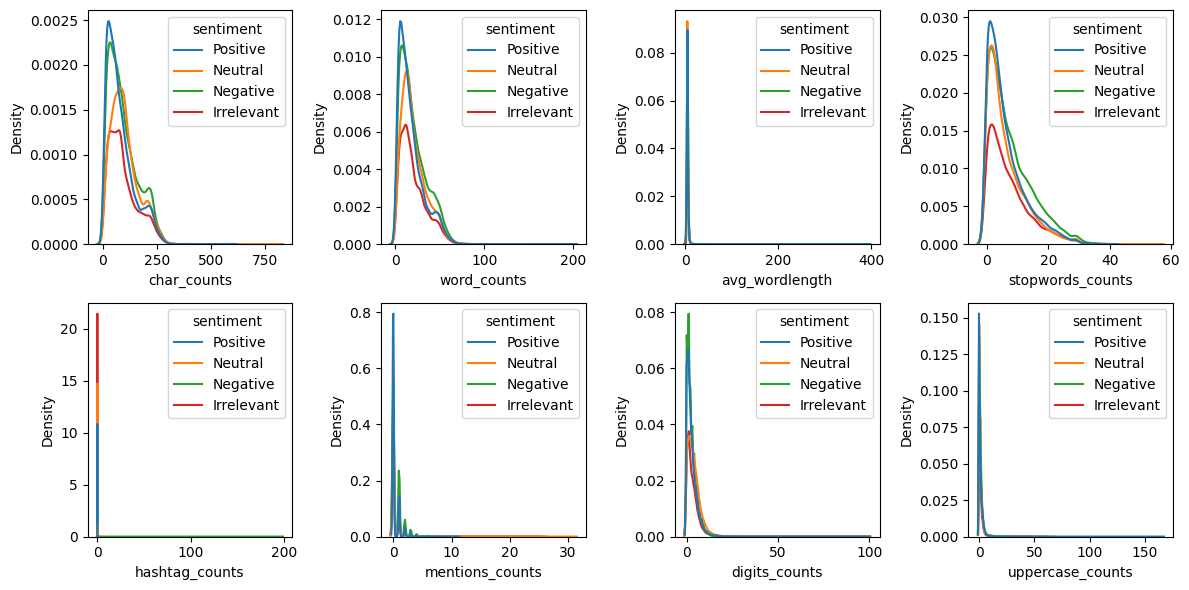

In [ ]:
plt.figure(figsize=(12,6))
num_cols=traindf.select_dtypes(include='number').columns
for index,col in enumerate(num_cols):
  plt.subplot(2,4,index+1)
  sns.kdeplot(data=traindf,x=col,hue='sentiment')
plt.tight_layout()
plt.show()

<Axes: ylabel='count'>

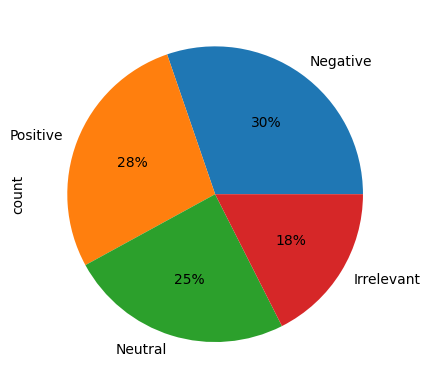

In [ ]:
traindf['sentiment'].value_counts().plot(kind='pie',autopct="%1.0f%%")

In [ ]:
#wordcloud visualization
#!pip install wordcloud
from wordcloud import WordCloud,STOPWORDS
stopwords=set(STOPWORDS)
#stopwords

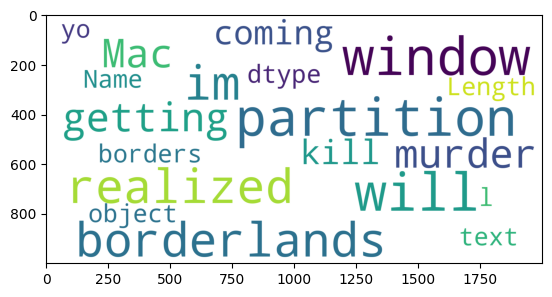

In [ ]:
wordcloud=WordCloud(background_color='white',stopwords=stopwords,max_words=500,max_font_size=42,
                    scale=5,contour_width=1,contour_color='steelblue').generate(str(traindf['text']))
plt.imshow(wordcloud)

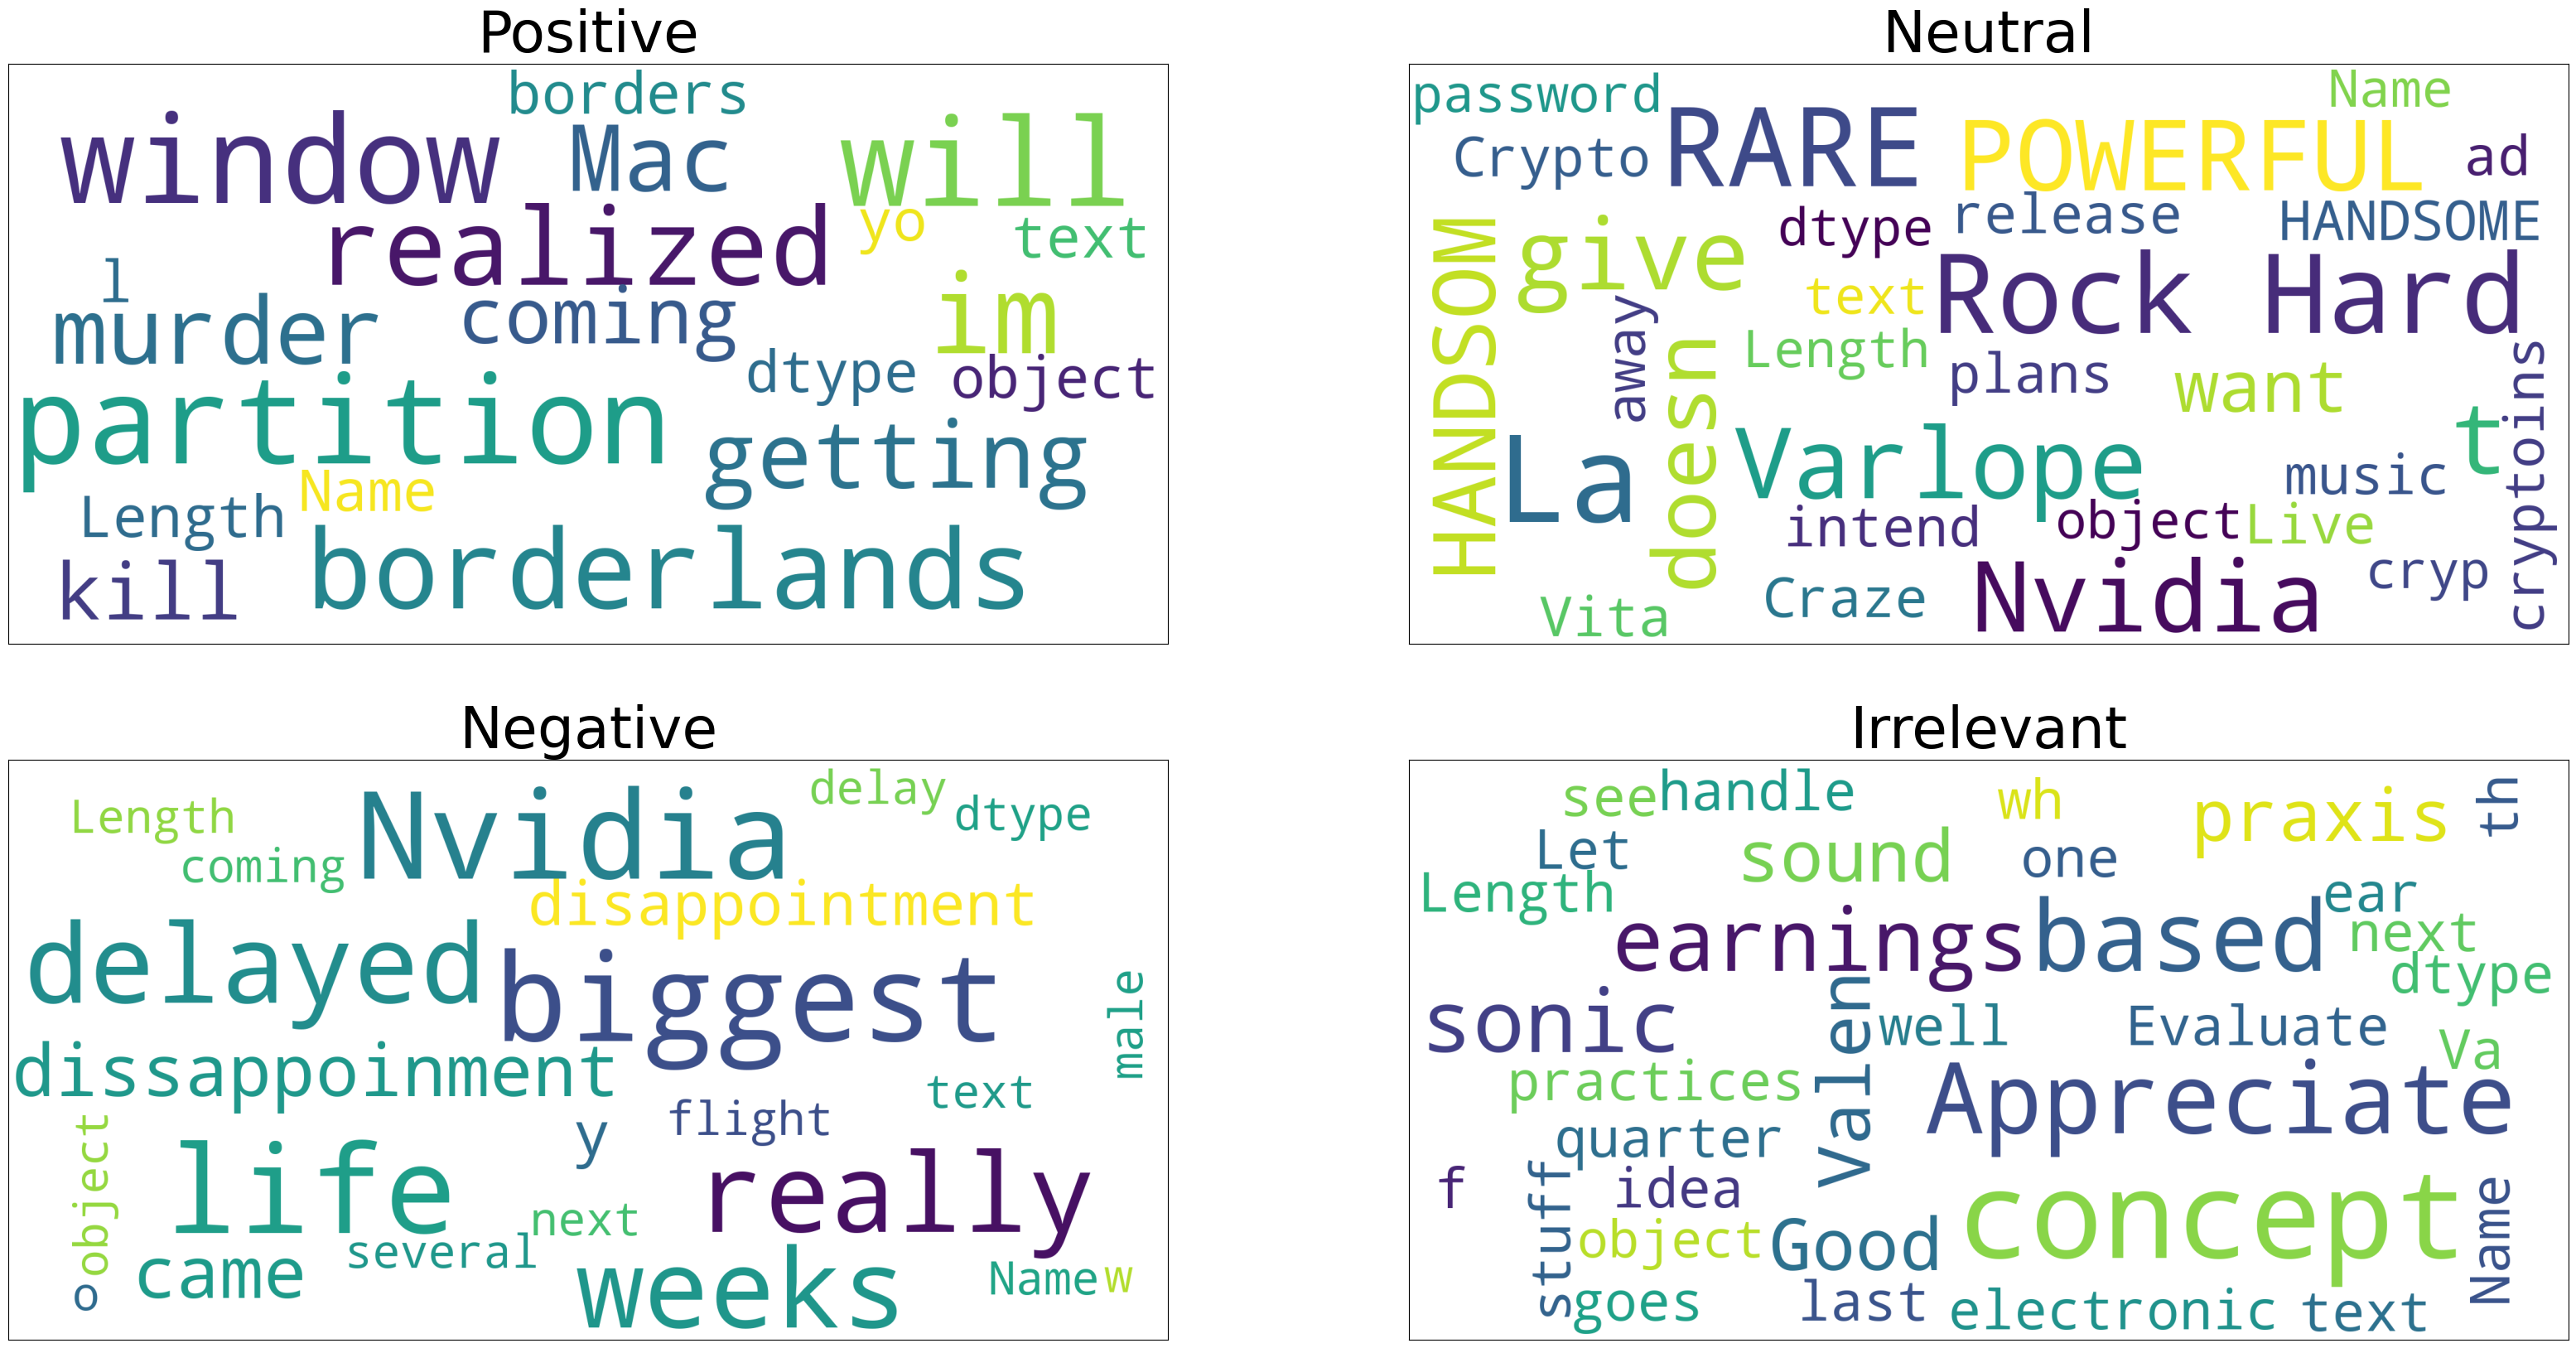

In [ ]:
plt.figure(figsize=(40,20))
for index,sentiment in enumerate(traindf['sentiment'].unique()):
  plt.subplot(2,2,index+1)
  data=traindf[traindf['sentiment']==sentiment]['text']
  wordcloud=WordCloud(background_color='white',stopwords=stopwords,max_words=500,max_font_size=42,
                    scale=5,contour_width=1,contour_color='steelblue').generate(str(data))
  plt.imshow(wordcloud)
  plt.xticks([])
  plt.yticks([])
  plt.title(sentiment,fontsize=50)



**DATA CLEANING**

In [ ]:
#lowercase normalization
traindf['text']=traindf['text'].apply(lambda x:x.lower())
#urls removal
traindf['text']=traindf['text'].apply(lambda x: ps.remove_urls(x))
#removing all tags
traindf['text']=traindf['text'].apply(lambda x: ps.remove_html_tags(x))
#removing all retweets
traindf['text']=traindf['text'].apply(lambda x: ps.remove_rt(x))
#removing special characters
traindf['text']=traindf['text'].apply(lambda x: ps.remove_special_chars(x))
#removing all tags
# Data Cleaning
# lowercase, remove url, html, punctuations, retweet



/usr/local/lib/python3.10/dist-packages/preprocess_kgptalkie/utils.py:97: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [ ]:
#lowercase normalization
testdf['text']=testdf['text'].apply(lambda x:x.lower())
#urls removal
testdf['text']=testdf['text'].apply(lambda x: ps.remove_urls(x))
#removing all tags
testdf['text']=testdf['text'].apply(lambda x: ps.remove_html_tags(x))
#removing all retweets
testdf['text']=testdf['text'].apply(lambda x: ps.remove_rt(x))
#removing special characters
testdf['text']=testdf['text'].apply(lambda x: ps.remove_special_chars(x))
#removing all tags


/usr/local/lib/python3.10/dist-packages/preprocess_kgptalkie/utils.py:97: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [ ]:

from sklearn.model_selection import train_test_split

# Separate features and labels in the training set
X_train = traindf['text']
y_train = traindf['sentiment']

# Separate features and labels in the validation set
X_test = testdf['text']
y_test = testdf['sentiment']

In [ ]:

X_test.shape,y_test.shape

((993,), (993,))

In [ ]:
X_train.shape,y_train.shape

((71890,), (71890,))

In [ ]:


y_test[:5]


0    Irrelevant
1       Neutral
2      Negative
3      Negative
4       Neutral
Name: sentiment, dtype: object

In [ ]:
y_train[:5]

0    Positive
1    Positive
2    Positive
3    Positive
4    Positive
Name: sentiment, dtype: object

In [ ]:
X_train.shape,y_train.shape

((71890,), (71890,))

**MODEL BUILDING**

In [ ]:
#tfid used for nlp for statistical representation of data
from sklearn.feature_extraction.text import TfidfVectorizer
#Here we are using Random Forest Classifier used for classifying tweets
from sklearn.ensemble import RandomForestClassifier
#to streamline processes in routine workflow
from sklearn.pipeline import Pipeline


In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (71890,)
y_train shape: (71890,)


In [ ]:
clf=Pipeline([('tfid',TfidfVectorizer()),('rfc',RandomForestClassifier(n_jobs=-1))])


In [ ]:
X_train.head()

0    im getting on borderlands and i will murder yo...
1    i am coming to the borders and i will kill you...
2    im getting on borderlands and i will kill you all
3    im coming on borderlands and i will murder you...
4    im getting on borderlands 2 and i will murder ...
Name: text, dtype: object

In [ ]:
clf.fit(X_train,y_train)

Pipeline(steps=[('tfid', TfidfVectorizer()),
                ('rfc', RandomForestClassifier(n_jobs=-1))])

**EVALUATION OF MODEL**

In [ ]:
from sklearn.metrics import classification_report
y_pred=clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

  Irrelevant       0.99      0.96      0.97       172
    Negative       0.95      0.97      0.96       262
     Neutral       0.97      0.96      0.97       285
    Positive       0.96      0.97      0.97       274

    accuracy                           0.97       993
   macro avg       0.97      0.97      0.97       993
weighted avg       0.97      0.97      0.97       993



**PREDICTION**

In [ ]:
clf.predict(['let me not upset you'])

array(['Negative'], dtype=object)

In [ ]:
clf.predict(['The enthusiasm in Palakkad is indicative of the strong support for NDA in Kerala. Here are some glimpses from the roadshow.'])

array(['Positive'], dtype=object)

In [ ]:
clf.predict(['i play borderland'])

array(['Neutral'], dtype=object)

In [ ]:
clf.predict(['happy for you'])

array(['Positive'], dtype=object)

In [ ]:
clf.predict(['sound quality ok'])

array(['Irrelevant'], dtype=object)

Saving the file as pkl to use in streamlit


In [ ]:
import joblib

In [ ]:
joblib.dump(clf, 'twitter_sentiment_model.pkl')

['twitter_sentiment_model.pkl']

In [ ]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.4 MB/s eta 0:00:00


In [ ]:
%%writefile app.py

Writing app.py


In [ ]:
! wget -q -O - ipv4.icanhazip.com

35.233.164.255


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.233.164.255:8501

npx: installed 22 in 4.83s
your url is: https://small-kings-unite.loca.lt
Neutral
Positive
Positive
Negative
Positive
Negative
Positive
Positive
